# Building a Neural Network from Scratch with Automatic Differentiation

## Introduction
This project demonstrates how to build a simple neural network from scratch using a custom Value class that supports automatic differentiation. The goal is to understand the fundamentals of neural networks, backpropagation, and gradient-based optimization by implementing everything from the ground up.

## Problem Statement
Neural networks are powerful machine learning models that can learn complex patterns from data. However, most modern deep learning frameworks (e.g., PyTorch, TensorFlow) abstract away the underlying mechanics, making it difficult to understand how these models work internally. In this project, I aim to:

- Build a custom autograd engine to compute gradients automatically.

- Use this engine to train a simple neural network on a toy dataset.

- Gain a deeper understanding of how neural networks learn and how backpropagation works.

## Approach
1. Autograd Engine:

We implement a Value class that represents a scalar value and supports basic operations like addition, multiplication, and activation functions (e.g., tanh).

The Value class automatically computes gradients using backpropagation, enabling us to train models using gradient descent.

2. Neural Network:

We define a simple feedforward neural network with one hidden layer and train it to solve a toy regression or classification problem.

The network is trained using stochastic gradient descent (SGD) to minimize a loss function (e.g., mean squared error for regression or cross-entropy for classification).

3. Training and Evaluation:

We train the network on a small dataset and monitor the loss over time.

We visualize the network's predictions and evaluate its performance.

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [224]:
import math

class Value:
    """
    A class that represents a scalar value and supports automatic differentiation.

    Attributes:
        data (float): The scalar value.
        grad (float): The gradient of the value with respect to some objective.
        _backward (function): A function to compute the gradient during backpropagation.
        _prev (set): A set of child nodes in the computation graph.
        _op (str): The operation that produced this value (e.g., '+', '*', 'tanh').
        label (str): A label for the value (useful for debugging and visualization).
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize a Value object.

        Args:
            data (float): The scalar value.
            _children (tuple): Child nodes in the computation graph.
            _op (str): The operation that produced this value.
            label (str): A label for the value.
        """
        self.data = data  # The scalar value
        self.grad = 0.0  # Gradient of the value (initialized to 0)
        self._backward = lambda: None  # Function to compute gradients during backpropagation
        self._prev = set(_children)  # Child nodes in the computation graph
        self._op = _op  # Operation that produced this value
        self.label = label  # Label for the value (useful for debugging)

    
    def __repr__(self):
        """Return a string representation of the Value object."""
        return f"Value(data={self.data})"

    
    def __add__(self, other):
        """
        Add two Value objects or a Value object and a scalar.
        Args:
            other (Value or float): The other value to add.
        Returns:
            Value: A new Value object representing the sum.
        """
        other = other if isinstance(other, Value) else Value(other)  # Ensure `other` is a Value object
        out = Value(self.data + other.data, (self, other), '+')  # Create a new Value for the sum

        def _backward():
            # Compute gradients for addition: d(out)/d(self) = 1, d(out)/d(other) = 1
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward  # Assign the backward function
        return out

    
    def __mul__(self, other):
        """
        Multiply two Value objects or a Value object and a scalar.
        Args:
            other (Value or float): The other value to multiply.
        Returns:
            Value: A new Value object representing the product.
        """
        other = other if isinstance(other, Value) else Value(other)  # Ensure `other` is a Value object
        out = Value(self.data * other.data, (self, other), '*')  # Create a new Value for the product

        def _backward():
            # Compute gradients for multiplication: d(out)/d(self) = other.data, d(out)/d(other) = self.data
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward  # Assign the backward function
        return out

    
    def tanh(self):
        """
        Apply the hyperbolic tangent (tanh) activation function to the value.
        Returns:
            Value: A new Value object representing tanh(self).
        """
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)  # Compute tanh(x)
        out = Value(t, (self,), 'tanh')  # Create a new Value for tanh(self)

        def _backward():
            # Compute gradient for tanh: d(tanh(x))/dx = 1 - tanh(x)^2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward  # Assign the backward function
        return out

    
    def __radd__(self, other):
        """
        Handle reverse addition (e.g., int + Value).
        Args:
            other (int or float): The scalar to add.
        Returns:
            Value: A new Value object representing the sum.
        """
        return self.__add__(other)  # Delegate to __add__

    
    def __rmul__(self, other):
        """
        Handle reverse multiplication (e.g., int * Value).
        Args:
            other (int or float): The scalar to multiply.
        Returns:
            Value: A new Value object representing the product.
        """
        return self * other  # Delegate to __mul__

    
    def __truediv__(self, other):
        """
        Divide this Value object by another Value object or scalar.
        Args:
            other (Value or float): The divisor.
        Returns:
            Value: A new Value object representing the quotient.
        """
        return self * (other**-1)  # Division is equivalent to multiplication by the reciprocal

    
    def __neg__(self):
        """
        Negate this Value object.
        Returns:
            Value: A new Value object representing the negation.
        """
        return self * -1  # Negation is equivalent to multiplication by -1

        
    def __sub__(self, other):
        """
        Subtract another Value object or scalar from this Value object.
        Args:
            other (Value or float): The value to subtract.
        Returns:
            Value: A new Value object representing the difference.
        """
        return self + (-other)  # Subtraction is equivalent to addition of the negation

    
    def __pow__(self, other):
        """
        Raise this Value object to a power.
        Args:
            other (int or float): The exponent.
        Returns:
            Value: A new Value object representing self^other.
        Raises:
            AssertionError: If `other` is not an int or float.
        """
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')  # Create a new Value for self^other

        def _backward():
            # Compute gradient for power: d(x^n)/dx = n * x^(n-1)
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward  # Assign the backward function
        return out

    
    def exp(self):
        """
        Compute the exponential of this Value object.
        Returns:
            Value: A new Value object representing exp(self).
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')  # Create a new Value for exp(self)

        def _backward():
            # Compute gradient for exp: d(exp(x))/dx = exp(x)
            self.grad += out.data * out.grad
        out._backward = _backward  # Assign the backward function
        return out

    
    def backward(self):
        """
        Perform backpropagation to compute gradients for all values in the computation graph.
        """
        topo = []  # Topological order of nodes
        visited = set()  # Set of visited nodes

        def build_topo(v):
            """Build a topological ordering of nodes using depth-first search."""
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)  # Build the topological order

        self.grad = 1.0  # Initialize the gradient of the output to 1
        for node in reversed(topo):  # Process nodes in reverse topological order
            node._backward()  # Compute gradients using the backward function

In [6]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron, b
b = Value(6.8813735870195432, label='b')

# (x1w1 + x2w2) + b = n
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
xiwi = x1w1 + x2w2; xiwi.label='x1w1 + x2w2'
n = xiwi + b; n.label = 'n'

# output o
o = n.tanh(); o.label='o'
o.backward()

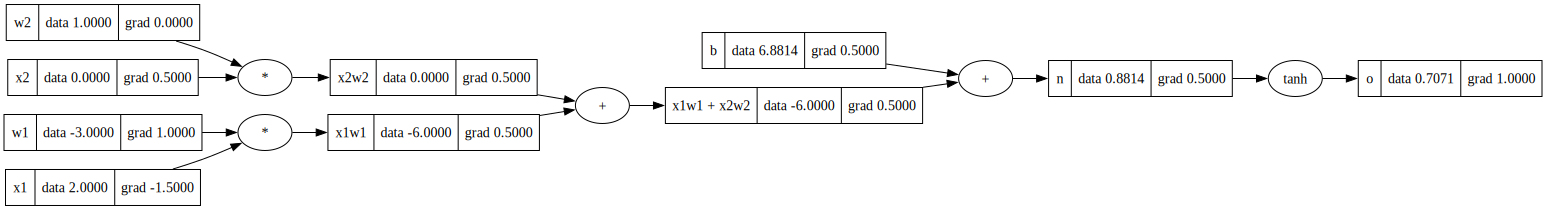

In [75]:
draw_dot(o)

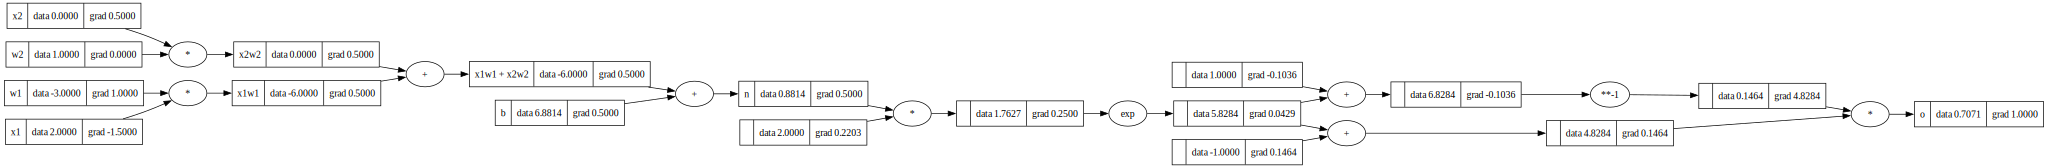

In [9]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron, b
b = Value(6.8813735870195432, label='b')

# (x1w1 + x2w2) + b = n
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
xiwi = x1w1 + x2w2; xiwi.label='x1w1 + x2w2'
n = xiwi + b; n.label = 'n'

# output o
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label='o'

o.backward()

draw_dot(o)

In [23]:
# Using Pytorch...

import torch

x1 = torch.Tensor([2.0]).double()              ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()              ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = (x1*w1 + x2*w2) + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('_____')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
_____
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [412]:
import random

class Neuron:
    """
    A single neuron in a neural network.
    Each neuron has a weight vector and a bias term.
    """
    def __init__(self, nin):
        """
        Initialize the neuron with random weights and a bias.
        Parameters:
        nin (int): Number of input connections.
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # Weights
        self.b = Value(random.uniform(-1,1)) # Bias

    
    def __call__(self, x):
        """
        Forward pass for the neuron.
        Computes the weighted sum of inputs plus bias, then applies tanh activation.
        
        Parameters:
        x (list of Value): Input values.
        
        Returns:
        Value: Activated output.
        """
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # Linear transformation
        out = act.tanh() # Non-linearity
        return out

    
    def parameters(self):
        """
        Returns all parameters (weights and bias) of the neuron.
        
        Returns:
        list of Value: Parameters of the neuron.
        """
        return self.w + [self.b]


class Layer:
    """
    A layer in a neural network, consisting of multiple neurons.
    """
    def __init__(self, nin, non):
        """
        Initialize the layer with nout neurons.
        
        Parameters:
        nin (int): Number of input connections per neuron.
        non (int): Number of neurons in the layer.
        """
        self.neurons = [Neuron(nin) for _ in range(non)]

    def __call__(self, x):
        """
        Forward pass through the layer.
        
        Parameters:
        x (list of Value): Input values.
        
        Returns:
        list of Value or Value: Output values from the neurons.
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # Return single value if only one neuron

    def parameters(self):
        """
        Returns all parameters of the layer (weights and biases of neurons).
        
        Returns:
        list of Value: Parameters of the layer.
        """
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    """
    A Multi-Layer Perceptron (MLP) consisting of multiple layers.
    """
    def __init__(self, nin, nouts):
        """
        Initialize the MLP with a given architecture.
        
        Parameters:
        nin (int): Number of input connections.
        nouts (list of int): Number of neurons in each layer.
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        """
        Forward pass through the entire MLP.
        
        Parameters:
        x (list of Value): Input values.
        
        Returns:
        list of Value or Value: Output from the final layer.
        """
        for layer in self.layers:
            x = layer(x) # Pass through each layer sequentially
        return x

    def parameters(self):
        """
        Returns all parameters of the MLP (weights and biases of all layers).
        
        Returns:
        list of Value: Parameters of the MLP.
        """
        return [p for layer in self.layers for p in layer.parameters()]


In [421]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

output = n(x)
output

Value(data=-0.10504283041569601)

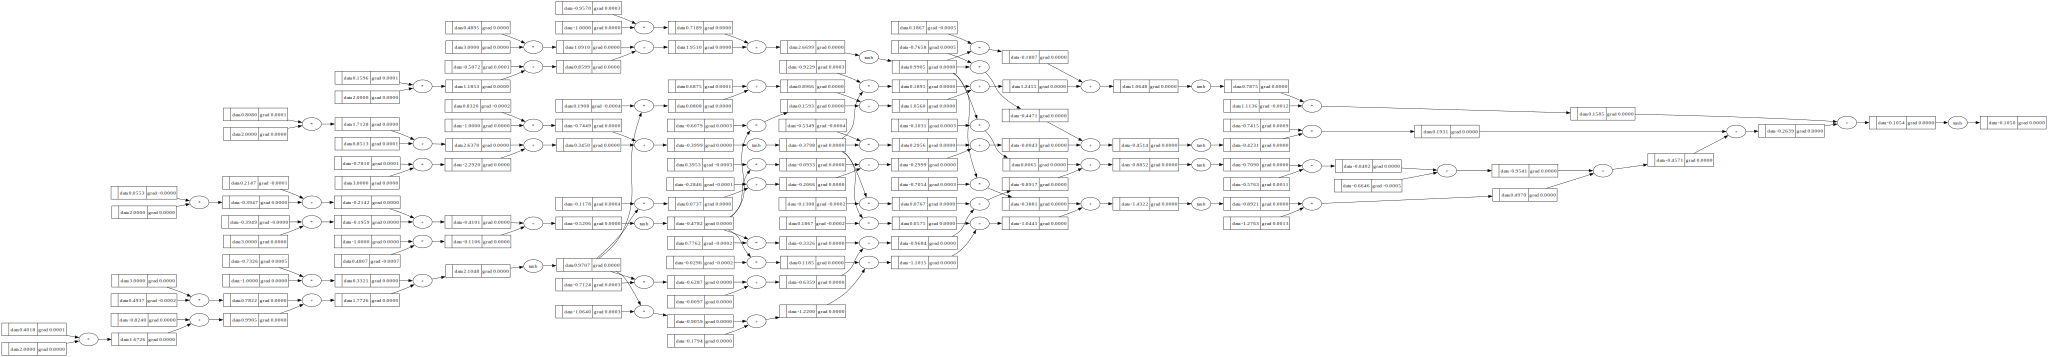

In [426]:
draw_dot(output)

In [423]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [424]:
# Training loop
for epoch in range(1000):  # Train for 10 epochs
    
    # Forward pass
    ypred = [n(x) for x in xs]
    
    # Compute loss
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

    # Zero gradients
    for p in n.parameters():
        p.grad = 0.0
        
    # Backward pass
    loss.backward()
    
    # Update weights and biases (gradient descent)
    for p in n.parameters():
        p.data -= 0.05 * p.grad  # Learning rate = 0.01

    # Print loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.data}")

Epoch 0, Loss: 3.6016318705751305
Epoch 100, Loss: 0.004849662245592051
Epoch 200, Loss: 0.002215677063403196
Epoch 300, Loss: 0.0014158001668587365
Epoch 400, Loss: 0.0010337856796143415
Epoch 500, Loss: 0.0008113099377133877
Epoch 600, Loss: 0.0006661873164304986
Epoch 700, Loss: 0.0005642730982627403
Epoch 800, Loss: 0.0004888854906795626
Epoch 900, Loss: 0.0004309251107868483


In [425]:
ypred # Final result of trained neural network

[Value(data=0.9921730608332369),
 Value(data=-0.9943452662820343),
 Value(data=-0.9902484685862049),
 Value(data=0.9859608954335344)]

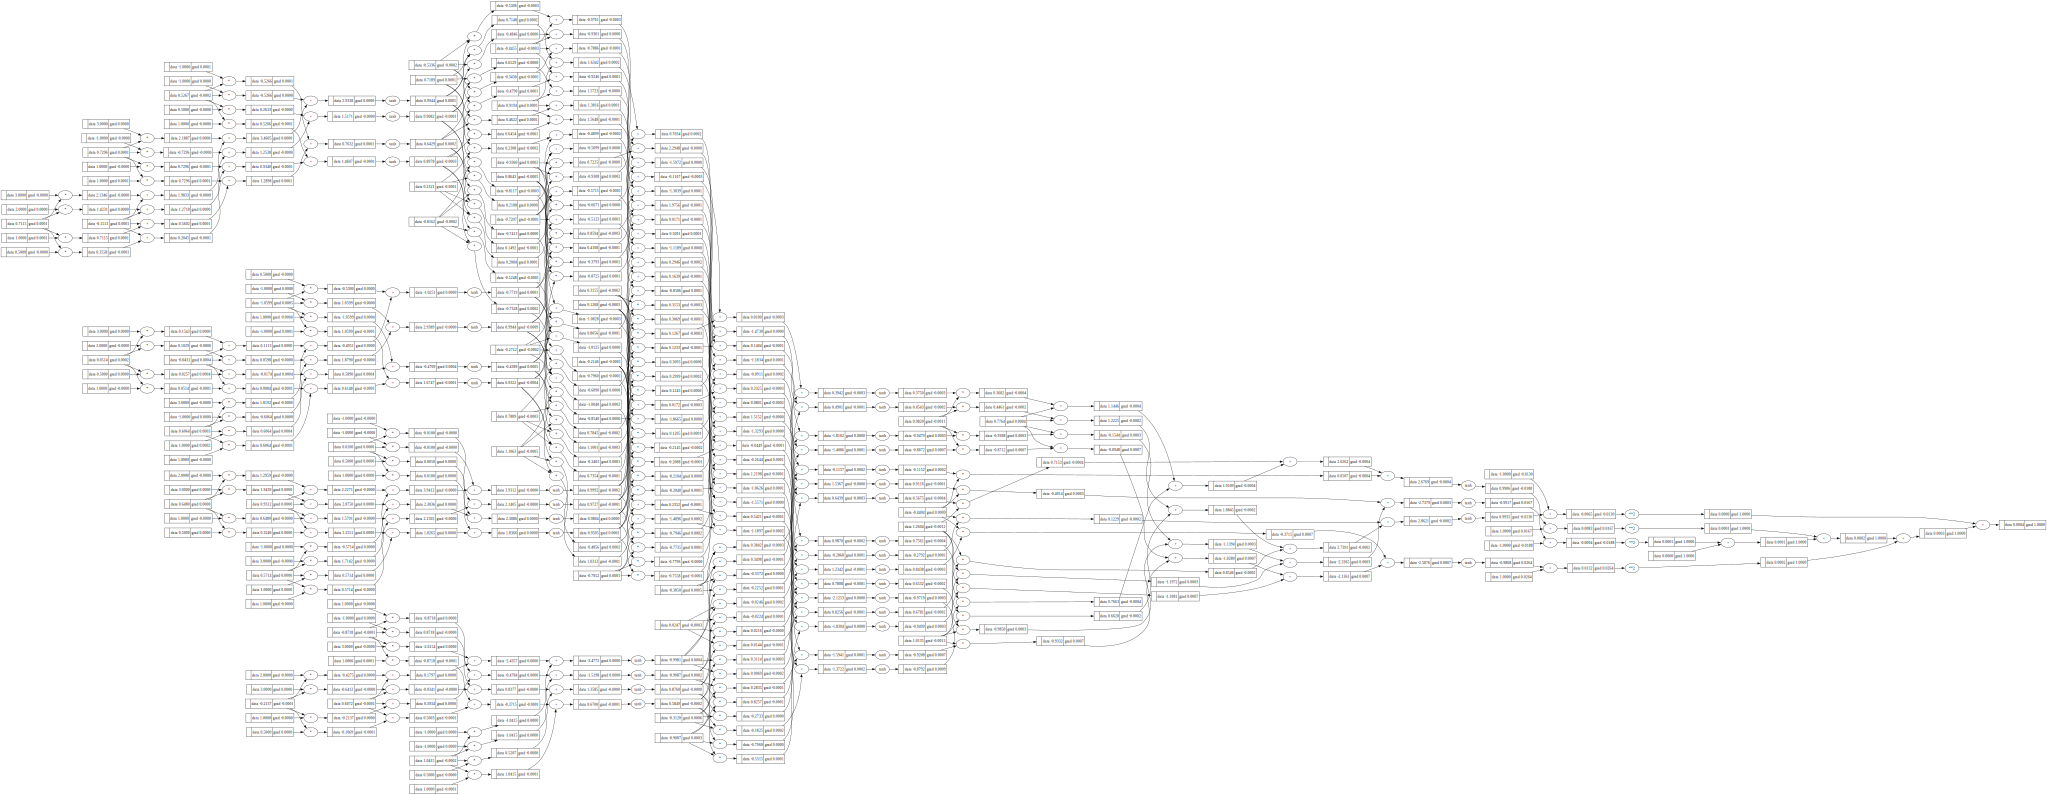

In [411]:
draw_dot(loss)